In [ ]:
#Importing Libraries
import pandas as pd
import numpy as np
from PIL import Image
from collections import Counter
import glob
import zipfile
import shutil
import cv2
import os
import re


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Exploratory Data Analysis of MARS Dataset


In [ ]:
#Reading Data
mars_train =pd.read_csv("drive/My Drive/mars/train_labels/train_labels_ma.csv")
mars_train.head()
mars_train

,IMAGE_ID,X1,Y1,X2,Y2,label
0,val_1.jp2,370.0,220.0,394.0,243.0,rockfall
1,val_1.jp2,311.0,391.0,342.0,423.0,rockfall
2,val_10.jp2,117.0,151.0,144.0,182.0,rockfall
3,val_11.jp2,236.0,112.0,270.0,178.0,rockfall
4,val_11.jp2,259.0,439.0,279.0,477.0,rockfall
...,...,...,...,...,...,...
1295,neg43.JP2,NaN,NaN,NaN,NaN,NaN
1296,neg44.JP2,NaN,NaN,NaN,NaN,NaN
1297,neg45.JP2,NaN,NaN,NaN,NaN,NaN
1298,neg46.JP2,NaN,NaN,NaN,NaN,NaN


In [ ]:
mars_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   IMAGE_ID  1300 non-null   object 
 1   X1        1000 non-null   float64
 2   Y1        1000 non-null   float64
 3   X2        1000 non-null   float64
 4   Y2        1000 non-null   float64
 5   label     1000 non-null   object 
dtypes: float64(4), object(2)
memory usage: 61.1+ KB


In [ ]:
#Count of number of missing data
missing_values_count = mars_train.isnull().sum()

#no. of missing values in each column
missing_values_count[0:6]

IMAGE_ID      0
X1          300
Y1          300
X2          300
Y2          300
label       300
dtype: int64

In [ ]:
#Creating the csv file, Dropping the missing values from the data and Reading the data after removing the duplicates
mars_train1 = mars_train.dropna()
mars_train1.to_csv('ylabel_mars.csv')

!cp ylabel_mars.csv "/content/drive/MyDrive/mars/y_label_mars"

y_label_temp = pd.read_csv("/content/drive/MyDrive/mars/y_label_mars/ylabel_mars.csv")

y_label_temp = mars_train1.loc[:, ~mars_train1.columns.str.contains('^Unnamed')]

y_label_temp

,IMAGE_ID,X1,Y1,X2,Y2,label
0,val_1.jp2,370.0,220.0,394.0,243.0,rockfall
1,val_1.jp2,311.0,391.0,342.0,423.0,rockfall
2,val_10.jp2,117.0,151.0,144.0,182.0,rockfall
3,val_11.jp2,236.0,112.0,270.0,178.0,rockfall
4,val_11.jp2,259.0,439.0,279.0,477.0,rockfall
...,...,...,...,...,...,...
995,l94.JP2,169.0,73.0,250.0,210.0,rockfall
996,l94.JP2,393.0,187.0,455.0,290.0,rockfall
997,l94.JP2,369.0,140.0,408.0,203.0,rockfall
998,l95.JP2,468.0,303.0,517.0,372.0,rockfall


In [ ]:
#Importing images from Drive to Colab

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/mars/train_images.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

#Number of images in the train_images dataset
len(os.listdir('/tmp/train_images/'))

758

In [ ]:
#Getting the extra details about the image
image = Image.open('/tmp/train_images/val_1.jp2')

#details about the image
print(image.format)
print(image.size)
print(image.mode)

JPEG2000
(676, 530)
L


In [ ]:
#List of duplicate Image IDs i.e. 778 rows
duplicate_mars = mars_train1[mars_train1.duplicated(['IMAGE_ID'], keep = False)]
duplicate_mars

,IMAGE_ID,X1,Y1,X2,Y2,label
0,val_1.jp2,370.0,220.0,394.0,243.0,rockfall
1,val_1.jp2,311.0,391.0,342.0,423.0,rockfall
3,val_11.jp2,236.0,112.0,270.0,178.0,rockfall
4,val_11.jp2,259.0,439.0,279.0,477.0,rockfall
5,val_12.jp2,169.0,350.0,191.0,387.0,rockfall
...,...,...,...,...,...,...
995,l94.JP2,169.0,73.0,250.0,210.0,rockfall
996,l94.JP2,393.0,187.0,455.0,290.0,rockfall
997,l94.JP2,369.0,140.0,408.0,203.0,rockfall
998,l95.JP2,468.0,303.0,517.0,372.0,rockfall


In [ ]:
#Filtering out the non-duplicates
nonDuplicates = mars_train1[~mars_train1.duplicated('IMAGE_ID')]

In [ ]:
#No. of duplicates  - 458
nonDuplicates['IMAGE_ID']

0       val_1.jp2
2      val_10.jp2
3      val_11.jp2
5      val_12.jp2
8      val_13.jp2
          ...    
991       l90.JP2
992       l91.JP2
993       l93.JP2
995       l94.JP2
998       l95.JP2
Name: IMAGE_ID, Length: 458, dtype: object

In [ ]:
#Storing the non-duplicates in 'temp' list
temp=[]
for i in nonDuplicates['IMAGE_ID']:
    if(~(duplicate_mars['IMAGE_ID'].eq(i)).any()):
        temp.append(i)

In [ ]:
#Filtering out the non-duplicates from duplicate_mars - 222
pathOfnonDuplicatedImages=[]
nonDupPath="/tmp/train_images/"
for dirname, _, filenames in os.walk(nonDupPath):
    for filename in filenames:
        if(filename in temp):
            pathOfnonDuplicatedImages.append(os.path.join(dirname, filename))
len(pathOfnonDuplicatedImages)

222

In [ ]:
#ylabel_mars has 1000 rows
!cp ylabel_mars.csv "/content/drive/MyDrive/mars/y_label_mars"

Creation of X_LABEL

In [ ]:
#Importing Image related Libraries
import cv2
import glob
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
#Need to do this later maybe
#Importing the images in a list (train_image) using CV2
""" train_image = []
path = "/tmp/train_images/*.*"
for file in glob.glob(path):
    #print(file)
    img = cv2.imread(file)
    train_image.append(img)
train_df = np.array(train_image)
train_df.shape """

' train_image = []  \npath = "/tmp/train_images/*.*"\nfor file in glob.glob(path):  \n    #print(file)    \n    img = cv2.imread(file)\n    train_image.append(img)\ntrain_df = np.array(train_image) \ntrain_df.shape '

In [ ]:
#Renaming the non-duplicate image
basePath='drive/My Drive/mars/x_label/'
suff='copy'
subsuff='_'
k=0
for i in pathOfnonDuplicatedImages:
    x=i.split('/')
    print(f'{basePath}{suff}{k}{subsuff}{x[3]}')
    shutil.copy(i,f'{basePath}{suff}{k}{subsuff}{x[3]}')

drive/My Drive/mars/x_label/copy0_val_153.jp2
drive/My Drive/mars/x_label/copy0_l23.JP2
drive/My Drive/mars/x_label/copy0_val_155.jp2
drive/My Drive/mars/x_label/copy0_newer0(25).jp2
drive/My Drive/mars/x_label/copy0_val_196.jp2
drive/My Drive/mars/x_label/copy0_l17.JP2
drive/My Drive/mars/x_label/copy0_newer0(19).jp2
drive/My Drive/mars/x_label/copy0_l12.JP2
drive/My Drive/mars/x_label/copy0_l70.JP2
drive/My Drive/mars/x_label/copy0_valnew.jp2
drive/My Drive/mars/x_label/copy0_l30.JP2
drive/My Drive/mars/x_label/copy0_lol25.jp2
drive/My Drive/mars/x_label/copy0_l62.JP2
drive/My Drive/mars/x_label/copy0_valnew(16).jp2
drive/My Drive/mars/x_label/copy0_val_131.jp2
drive/My Drive/mars/x_label/copy0_newer0(1).jp2
drive/My Drive/mars/x_label/copy0_l36.JP2
drive/My Drive/mars/x_label/copy0_valnew(5).jp2
drive/My Drive/mars/x_label/copy0_val_156.jp2
drive/My Drive/mars/x_label/copy0_val_101.jp2
drive/My Drive/mars/x_label/copy0_l1.JP2
drive/My Drive/mars/x_label/copy0_l64.JP2
drive/My Drive/

In [ ]:
#Storing the duplicate images
import re
pathOfDuplicatedImages=[]
path = '/tmp/train_images/'
dupList = duplicate_mars['IMAGE_ID']
suff='.jp2'
print(dupList)
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
         y=re.findall('[0-9]+', filename)
         #if((duplicate_mars['IMAGE_ID'].eq(filename)).any()):
         pathOfDuplicatedImages.append(os.path.join(dirname, filename))


#print(pathOfDuplicatedImages)


0       val_1.jp2
1       val_1.jp2
3      val_11.jp2
4      val_11.jp2
5      val_12.jp2
          ...    
995       l94.JP2
996       l94.JP2
997       l94.JP2
998       l95.JP2
999       l95.JP2
Name: IMAGE_ID, Length: 778, dtype: object


In [ ]:
import shutil
path='/content/drive/MyDrive/mars/x_label_mars/'

In [ ]:
#Creating a dictionary to check how many copy of each image is there
from collections import Counter
counts = dict(Counter(duplicate_mars['IMAGE_ID']))
duplicatesImg = {key:value for key, value in counts.items() if value > 1}
print(duplicatesImg)

{'val_1.jp2': 2, 'val_11.jp2': 2, 'val_12.jp2': 3, 'val_13.jp2': 3, 'val_14.jp2': 2, 'val_15.jp2': 3, 'val_16.jp2': 4, 'val_17.jp2': 6, 'val_18.jp2': 4, 'val_19.jp2': 2, 'val_21.jp2': 2, 'val_22.jp2': 5, 'val_23.jp2': 5, 'val_27.jp2': 2, 'val_28.jp2': 3, 'val_29.jp2': 2, 'val_31.jp2': 3, 'val_32.jp2': 7, 'val_33.jp2': 6, 'val_34.jp2': 2, 'val_35.jp2': 16, 'val_36.jp2': 6, 'val_37.jp2': 6, 'val_38.jp2': 8, 'val_39.jp2': 8, 'val_4.jp2': 2, 'val_40.jp2': 4, 'val_5.jp2': 2, 'val_6.jp2': 6, 'val_7.jp2': 6, 'val_8.jp2': 4, 'val_9.jp2': 2, 'val_41.jp2': 2, 'val_46.jp2': 2, 'val_49.jp2': 2, 'val_50.jp2': 3, 'val_51.jp2': 2, 'val_52.jp2': 3, 'val_58.jp2': 2, 'val_59.jp2': 4, 'val_60.jp2': 2, 'val_63.jp2': 2, 'val_64.jp2': 2, 'val_65.jp2': 2, 'val_68.jp2': 2, 'val_70.jp2': 4, 'val_74.jp2': 4, 'val_76.jp2': 2, 'val_78.jp2': 2, 'val_79.jp2': 4, 'val_100.jp2': 7, 'val_102.jp2': 2, 'val_103.jp2': 2, 'val_104.jp2': 3, 'val_105.jp2': 5, 'val_106.jp2': 7, 'val_107.jp2': 8, 'val_108.jp2': 2, 'val_110.jp

In [ ]:
for i in pathOfDuplicatedImages:
    x=i.split('/')
    temp = 'copy'
    temp1 = '_'
    print(x)
    for j in duplicatesImg.keys():
        if(x[3]==j):
            y=duplicatesImg.get(j)
            for k in range(0,y):
                shutil.copy(i, f'{path}{temp}{k}{temp1}{x[3]}')

['', 'tmp', 'train_images', 'val_103.jp2']
['', 'tmp', 'train_images', 'neg216.JP2']
['', 'tmp', 'train_images', 'l56.JP2']
['', 'tmp', 'train_images', 'neg134.JP2']
['', 'tmp', 'train_images', 'val_182.jp2']
['', 'tmp', 'train_images', 'lol2.jp2']
['', 'tmp', 'train_images', 'val_64.jp2']
['', 'tmp', 'train_images', 'val_153.jp2']
['', 'tmp', 'train_images', 'newer0(69).jp2']
['', 'tmp', 'train_images', 'val_132.jp2']
['', 'tmp', 'train_images', 'val_21.jp2']
['', 'tmp', 'train_images', 'neg143.JP2']
['', 'tmp', 'train_images', 'neg293.JP2']
['', 'tmp', 'train_images', 'neg284.JP2']
['', 'tmp', 'train_images', 'val_29.jp2']
['', 'tmp', 'train_images', 'l23.JP2']
['', 'tmp', 'train_images', 'val_155.jp2']
['', 'tmp', 'train_images', 'newer0(25).jp2']
['', 'tmp', 'train_images', 'neg220.JP2']
['', 'tmp', 'train_images', 'neg248.JP2']
['', 'tmp', 'train_images', 'val_8.jp2']
['', 'tmp', 'train_images', 'neg292.JP2']
['', 'tmp', 'train_images', 'val_196.jp2']
['', 'tmp', 'train_images', '

In [ ]:
#Check - 458
nonDuplicates['IMAGE_ID']

0       val_1.jp2
2      val_10.jp2
3      val_11.jp2
5      val_12.jp2
8      val_13.jp2
          ...    
991       l90.JP2
992       l91.JP2
993       l93.JP2
995       l94.JP2
998       l95.JP2
Name: IMAGE_ID, Length: 458, dtype: object

In [ ]:
#Check - 778
duplicate_mars['IMAGE_ID']

0       val_1.jp2
1       val_1.jp2
3      val_11.jp2
4      val_11.jp2
5      val_12.jp2
          ...    
995       l94.JP2
996       l94.JP2
997       l94.JP2
998       l95.JP2
999       l95.JP2
Name: IMAGE_ID, Length: 778, dtype: object

In [ ]:
#NO NEED
newdf1 = mars_train1[mars_train1-mars_train1.duplicated('IMAGE_ID')]
newdf1

,IMAGE_ID,X1,Y1,X2,Y2,label
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
995,NaN,NaN,NaN,NaN,NaN,NaN
996,NaN,NaN,NaN,NaN,NaN,NaN
997,NaN,NaN,NaN,NaN,NaN,NaN
998,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
basePath='/content/drive/MyDrive/mars/x_label_mars'
suff='copy'
subsuff='_'
k=0
for i in pathOfnonDuplicatedImages:
    x=i.split('/')
#     print(f'{path}{suff}{k}{subsuff}{x[3]}')
    shutil.copy(i,f'{path}{suff}{k}{subsuff}{x[3]}')

In [ ]:
IMAGE_DIR='/content/drive/MyDrive/mars/x_label_mars'
# ANNOT_DIR='/kaggle/working/y_label/'
# listdir generates a list of all the files in the directory and return a python list of string file names
images_name_list = os.listdir(IMAGE_DIR)

In [ ]:
image_id = mars_train1['IMAGE_ID'].to_list()

In [ ]:
len(image_id)

1000

In [ ]:
temp=[]
temp = sorted(image_id)

In [ ]:
#Resizing the image
from skimage import io
X=[]
temp=[]
Img_Path='/content/drive/MyDrive/mars/x_label_mars'
prefix='copy1_'
prefix1='copy0_'
for dirname, _, filenames in os.walk(Img_Path):
        for i in image_id:
            try:
                x=(os.path.join(dirname,f'{prefix1}{i}'))
                image= io.imread(x)
            except:
                x=(os.path.join(dirname,f'{prefix}{i}'))
                image= io.imread(x)
            image=cv2.resize(image,(200, 200),interpolation = cv2.INTER_AREA)
            image=np.array(image)
            image = image.astype('float32')
            image /= 255
            X.append(image)



In [ ]:
len(X)

1000

In [ ]:
#X_dash - converts into float
X_dash=np.asarray(X, dtype = np.float32)

In [ ]:
print('X_shape before reshaping',X_dash.shape)

X_shape before reshaping (1000, 200, 200)


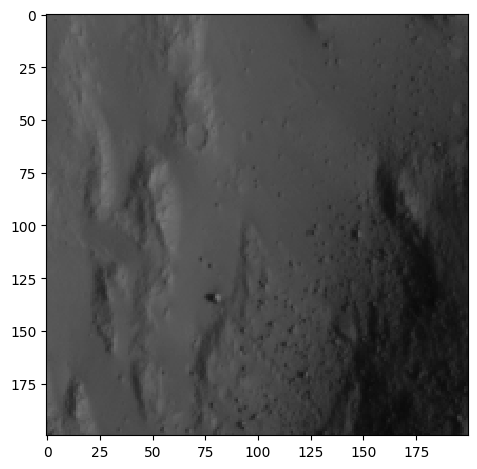

In [ ]:
io.imshow(X_dash[1])

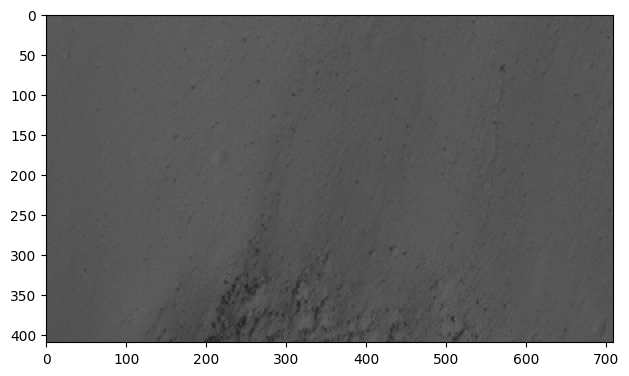

In [ ]:
io.imshow('/content/drive/MyDrive/mars/x_label_mars/copy0_l1.JP2')

In [ ]:
image_id_y=[]
for i in image_id:
    a=i.split('.')
    image_id_y.append(a[0])
image_id_y = np.array(image_id_y).astype(np.float32)

In [ ]:
len(image_id_y)

1000

In [ ]:
co_ords=['X1','Y1','X2','Y2']
df2=mars_train1[co_ords]

In [ ]:
y_dash= np.asarray(df2, dtype = np.float32)

In [ ]:
y_dash.shape

(1000, 4)

In [ ]:
y_dash[0]

array([370., 220., 394., 243.], dtype=float32)

Creation of Bounding Box

In [ ]:
xmin=148
ymin=40
xmax=183
ymax=125

In [ ]:
w= xmax-xmin
h=ymax-ymin
# Image_Width=200
# Image_Height=200

In [ ]:
n_w=w/200
n_h=h/200

In [ ]:
n_xmin= (xmin+w/2)/200
n_xmax= (xmax+w/2)/200
n_ymin=(ymin+w/2)/200
n_ymax= (ymax+w/2)/200

In [ ]:
xmin=xmin/200
ymin=ymin/200
xmax=xmax/200
ymax=ymax/200

In [ ]:
new_xmin= (xmin+n_w/2)/200
new_xmax=(xmax+n_w)/200
new_ymin=(ymin+n_h)/200
new_ymax=(ymax+n_h)/200

In [ ]:
print(new_xmin*200)
print(new_xmax*200)
print(new_ymin*200)
print(new_ymax*200)

0.8274999999999999
1.09
0.625
1.05


In [ ]:
n_w=n_w*200
print(n_w)

35.0


In [ ]:
n_h=n_h*200
print(n_h)

85.0


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

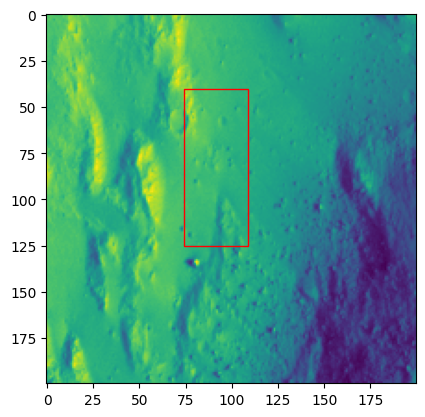

In [ ]:
rect = patches.Rectangle((74, 40),n_w, n_h, linewidth=1, edgecolor='r', facecolor='none')
fig, ax = plt.subplots()

# Display the image
ax.imshow(X_dash[0])
ax.add_patch(rect)
plt.show()

In [ ]:
y_dash[1]

array([311., 391., 342., 423.], dtype=float32)

In [ ]:
duplicate_mars.head

<bound method NDFrame.head of        IMAGE_ID     X1     Y1     X2     Y2     label
0     val_1.jp2  370.0  220.0  394.0  243.0  rockfall
1     val_1.jp2  311.0  391.0  342.0  423.0  rockfall
3    val_11.jp2  236.0  112.0  270.0  178.0  rockfall
4    val_11.jp2  259.0  439.0  279.0  477.0  rockfall
5    val_12.jp2  169.0  350.0  191.0  387.0  rockfall
..          ...    ...    ...    ...    ...       ...
995     l94.JP2  169.0   73.0  250.0  210.0  rockfall
996     l94.JP2  393.0  187.0  455.0  290.0  rockfall
997     l94.JP2  369.0  140.0  408.0  203.0  rockfall
998     l95.JP2  468.0  303.0  517.0  372.0  rockfall
999     l95.JP2  708.0  484.0  801.0  664.0  rockfall

[778 rows x 6 columns]>

In [ ]:
image = io.imread('/content/drive/MyDrive/mars/train_images/val_1.jp2')
image.shape

(530, 676)

Normalizing the Co-ordinates


In [ ]:
xmax=394/530
xmin=370/530
ymin=243/676
ymax=220/676

In [ ]:
print(xmin*200)

139.62264150943395


In [ ]:
n_xmax=xmax*200
n_min=xmin*200

In [ ]:
n_ymax=ymax*200
n_ymin=ymin*200

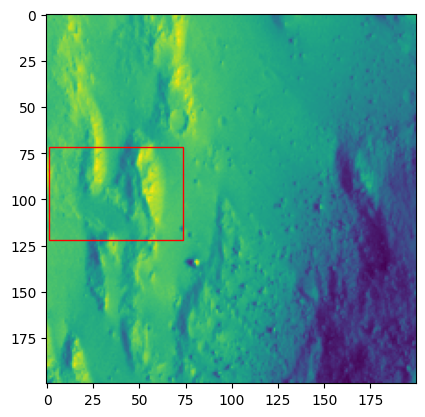

In [ ]:
import matplotlib.pyplot as plt
rect = patches.Rectangle((n_xmin, n_ymin),73,50 , linewidth=1, edgecolor='r', facecolor='none')
fig, ax = plt.subplots()

# Display the image
ax.imshow(X_dash[1])
ax.add_patch(rect)
plt.show()

In [ ]:
corodsList=sorted(pathOfDuplicatedImages)

In [ ]:
a=list(duplicate_mars["IMAGE_ID"])

In [ ]:
a=sorted(a)
a

['l10.JP2',
 'l10.JP2',
 'l10.JP2',
 'l100.JP2',
 'l100.JP2',
 'l100.JP2',
 'l100.JP2',
 'l13.JP2',
 'l13.JP2',
 'l15.JP2',
 'l15.JP2',
 'l19.JP2',
 'l19.JP2',
 'l25.JP2',
 'l25.JP2',
 'l26.JP2',
 'l26.JP2',
 'l26.JP2',
 'l35.JP2',
 'l35.JP2',
 'l35.JP2',
 'l37.JP2',
 'l37.JP2',
 'l37.JP2',
 'l43.JP2',
 'l43.JP2',
 'l44.JP2',
 'l44.JP2',
 'l46.JP2',
 'l46.JP2',
 'l48.JP2',
 'l48.JP2',
 'l48.JP2',
 'l48.JP2',
 'l5.JP2',
 'l5.JP2',
 'l5.JP2',
 'l50.JP2',
 'l50.JP2',
 'l50.JP2',
 'l50.JP2',
 'l50.JP2',
 'l50.JP2',
 'l51.JP2',
 'l51.JP2',
 'l51.JP2',
 'l51.JP2',
 'l51.JP2',
 'l51.JP2',
 'l51.JP2',
 'l51.JP2',
 'l51.JP2',
 'l51.JP2',
 'l51.JP2',
 'l52.JP2',
 'l52.JP2',
 'l53.JP2',
 'l53.JP2',
 'l53.JP2',
 'l53.JP2',
 'l53.JP2',
 'l56.JP2',
 'l56.JP2',
 'l56.JP2',
 'l56.JP2',
 'l56.JP2',
 'l57.JP2',
 'l57.JP2',
 'l58.JP2',
 'l58.JP2',
 'l59.JP2',
 'l59.JP2',
 'l59.JP2',
 'l60.JP2',
 'l60.JP2',
 'l63.JP2',
 'l63.JP2',
 'l63.JP2',
 'l63.JP2',
 'l65.JP2',
 'l65.JP2',
 'l68.JP2',
 'l68.JP2',
 'l

In [ ]:
pa = '/content/drive/MyDrive/mars/train_images/*.*'
dic={}
for i in glob.glob(pa):
    numbers = i.split('/')
    #print(numbers)
    img = io.imread(i)
    shape=img.shape
    dic.update({numbers[6]:shape})
dic

{'back1.jp2': (177, 239),
 'back10.jp2': (347, 571),
 'back16.jp2': (520, 840),
 'back12.jp2': (101, 110),
 'back11.jp2': (102, 131),
 'back14.jp2': (229, 313),
 'back15.jp2': (351, 578),
 'back13.jp2': (458, 740),
 'back25.jp2': (120, 596),
 'back3.jp2': (578, 551),
 'back2.jp2': (206, 209),
 'back22.jp2': (352, 580),
 'back27.jp2': (240, 143),
 'back23.jp2': (478, 787),
 'back4.jp2': (337, 545),
 'back24.jp2': (515, 846),
 'back20.jp2': (277, 169),
 'back19.jp2': (167, 200),
 'back17.jp2': (455, 749),
 'back26.jp2': (603, 994),
 'back18.jp2': (147, 193),
 'back21.jp2': (518, 855),
 'back5.jp2': (310, 253),
 'l11.JP2': (820, 1418),
 'back8.jp2': (229, 199),
 'l10.JP2': (820, 1418),
 'l15.JP2': (205, 355),
 'back9.jp2': (389, 628),
 'l100.JP2': (533, 922),
 'l13.JP2': (820, 1418),
 'back7.jp2': (356, 274),
 'l12.JP2': (820, 1418),
 'l14.JP2': (410, 709),
 'back6.jp2': (494, 814),
 'l1.JP2': (410, 709),
 'l19.JP2': (410, 709),
 'l20.JP2': (205, 355),
 'l22.JP2': (215, 372),
 'l26.JP2': 

In [ ]:
dic.get('val_193.jp2')

(614, 783)

In [ ]:
mars_train1.head

<bound method NDFrame.head of        IMAGE_ID     X1     Y1     X2     Y2     label
0     val_1.jp2  370.0  220.0  394.0  243.0  rockfall
1     val_1.jp2  311.0  391.0  342.0  423.0  rockfall
2    val_10.jp2  117.0  151.0  144.0  182.0  rockfall
3    val_11.jp2  236.0  112.0  270.0  178.0  rockfall
4    val_11.jp2  259.0  439.0  279.0  477.0  rockfall
..          ...    ...    ...    ...    ...       ...
995     l94.JP2  169.0   73.0  250.0  210.0  rockfall
996     l94.JP2  393.0  187.0  455.0  290.0  rockfall
997     l94.JP2  369.0  140.0  408.0  203.0  rockfall
998     l95.JP2  468.0  303.0  517.0  372.0  rockfall
999     l95.JP2  708.0  484.0  801.0  664.0  rockfall

[1000 rows x 6 columns]>

In [ ]:
duplicate_mars

,IMAGE_ID,X1,Y1,X2,Y2,label
0,val_1.jp2,370.0,220.0,394.0,243.0,rockfall
1,val_1.jp2,311.0,391.0,342.0,423.0,rockfall
3,val_11.jp2,236.0,112.0,270.0,178.0,rockfall
4,val_11.jp2,259.0,439.0,279.0,477.0,rockfall
5,val_12.jp2,169.0,350.0,191.0,387.0,rockfall
...,...,...,...,...,...,...
995,l94.JP2,169.0,73.0,250.0,210.0,rockfall
996,l94.JP2,393.0,187.0,455.0,290.0,rockfall
997,l94.JP2,369.0,140.0,408.0,203.0,rockfall
998,l95.JP2,468.0,303.0,517.0,372.0,rockfall


In [ ]:
x1List=[]
y1List=[]
x2List=[]
y2List=[]
for i in range(0,mars_train1['IMAGE_ID'].size):
    x1=(mars_train1.loc[i]['X1'])
    y1=(mars_train1.loc[i]['Y1'])
    x2=(mars_train1.loc[i]['X2'])
    y2=(mars_train1.loc[i]['Y2'])
    #print(x1)
    dic_id=(mars_train1.loc[i]['IMAGE_ID'])
    print(dic_id)
    shapeList=dic.get(dic_id)
    print(f'"{x1}","{x2}","{y1}","{y2}"')


    print(shapeList)
    x1=x1/shapeList[0]
    x2=x2/shapeList[0]
    x1List.append(x1*200)
    x2List.append(x2*200)
    y1=y1/shapeList[1]
    y2=y2/shapeList[1]
    y1List.append(y1*200)
    y2List.append(y2*200)
    print(f'{x1}","{x2}","{y1}","{y2}')


val_1.jp2
"370.0","394.0","220.0","243.0"
(530, 676)
0.6981132075471698","0.7433962264150943","0.3254437869822485","0.3594674556213018
val_1.jp2
"311.0","342.0","391.0","423.0"
(530, 676)
0.5867924528301887","0.6452830188679245","0.5784023668639053","0.6257396449704142
val_10.jp2
"117.0","144.0","151.0","182.0"
(298, 380)
0.3926174496644295","0.48322147651006714","0.3973684210526316","0.4789473684210526
val_11.jp2
"236.0","270.0","112.0","178.0"
(530, 676)
0.44528301886792454","0.5094339622641509","0.16568047337278108","0.26331360946745563
val_11.jp2
"259.0","279.0","439.0","477.0"
(530, 676)
0.48867924528301887","0.5264150943396226","0.6494082840236687","0.7056213017751479
val_12.jp2
"169.0","191.0","350.0","387.0"
(530, 676)
0.31886792452830187","0.360377358490566","0.5177514792899408","0.5724852071005917
val_12.jp2
"429.0","484.0","193.0","238.0"
(530, 676)
0.809433962264151","0.9132075471698113","0.28550295857988167","0.3520710059171598
val_12.jp2
"207.0","272.0","338.0","388.0"
(5

In [ ]:
normalizedCo_ords= pd.DataFrame(columns=['Xmin','Ymin','Xmax','Ymax'])

In [ ]:
xmin_nor= pd.Series(x1List)
xmax_nor= pd.Series(x2List)
ymin_nor= pd.Series(y1List)
ymax_nor= pd.Series(y2List)

In [ ]:
normalizedCo_ords['Xmin']=x1List
normalizedCo_ords['Xmax']=x2List
normalizedCo_ords['Ymin']=y1List
normalizedCo_ords['Ymax']=y2List

In [ ]:
normalizedCo_ords

,Xmin,Ymin,Xmax,Ymax
0,139.622642,65.088757,148.679245,71.893491
1,117.358491,115.680473,129.056604,125.147929
2,78.523490,79.473684,96.644295,95.789474
3,89.056604,33.136095,101.886792,52.662722
4,97.735849,129.881657,105.283019,141.124260
...,...,...,...,...
995,91.598916,22.884013,135.501355,65.830721
996,213.008130,58.620690,246.612466,90.909091
997,200.000000,43.887147,221.138211,63.636364
998,126.829268,47.492163,140.108401,58.307210


In [ ]:
y_dash=normalizedCo_ords

In [ ]:
y_dash.shape

(1000, 4)

In [ ]:
X_dash.shape

(1000, 200, 200)

In [ ]:
y_dash.head

<bound method NDFrame.head of            Xmin        Ymin        Xmax        Ymax
0    139.622642   65.088757  148.679245   71.893491
1    117.358491  115.680473  129.056604  125.147929
2     78.523490   79.473684   96.644295   95.789474
3     89.056604   33.136095  101.886792   52.662722
4     97.735849  129.881657  105.283019  141.124260
..          ...         ...         ...         ...
995   91.598916   22.884013  135.501355   65.830721
996  213.008130   58.620690  246.612466   90.909091
997  200.000000   43.887147  221.138211   63.636364
998  126.829268   47.492163  140.108401   58.307210
999  191.869919   75.862069  217.073171  104.075235

[1000 rows x 4 columns]>

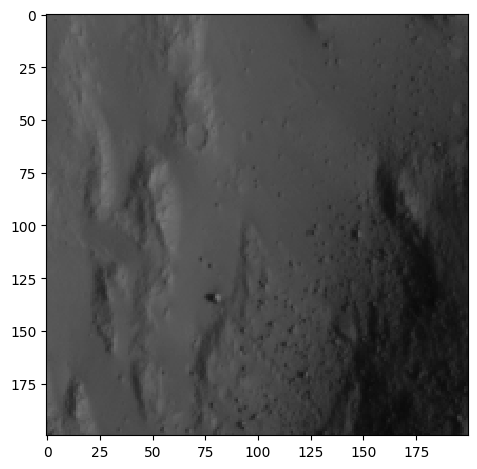

In [ ]:
io.imshow(X_dash[0])

In [ ]:
import os
path = "/content/drive/MyDrive/mars/x_label_mars/"
fileList=os.listdir(path)
print(len(fileList))

1000


**MODELING**

In [ ]:
import tensorflow as tf
y_tensor=tf.convert_to_tensor(df2)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X_dash,y_dash,random_state=104, test_size=0.25,shuffle=True)

In [ ]:
X_train.shape

(750, 200, 200)

In [ ]:
y_train.shape

(750, 4)

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16
model = Sequential()
model.add(Conv2D(1024, (3, 3), activation='relu', input_shape=(200, 200,1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(Dense(128, activation ='relu'))
model.add(Dense(64, activation ='relu'))
model.add(Dense(4, activation = "softmax"))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 1024)    10240     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 1024)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 512)       4719104   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 512)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 256)       1179904   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 256)      0

In [ ]:
model.compile(optimizer='adam',
              loss = "mse",
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=4, batch_size = 4)

Epoch 1/4
188/188 [==============================] - 4709s 25s/step - loss: 14848.1904 - accuracy: 0.7920
Epoch 2/4
188/188 [==============================] - 4688s 25s/step - loss: 14848.1201 - accuracy: 0.8013
Epoch 3/4
188/188 [==============================] - 4761s 25s/step - loss: 14848.1064 - accuracy: 0.8013
Epoch 4/4
188/188 [==============================] - 4725s 25s/step - loss: 14848.1143 - accuracy: 0.8013


In [ ]:
preds = model.predict(X_test)

8/8 [==============================] - 461s 56s/step


In [ ]:
len(preds)

250